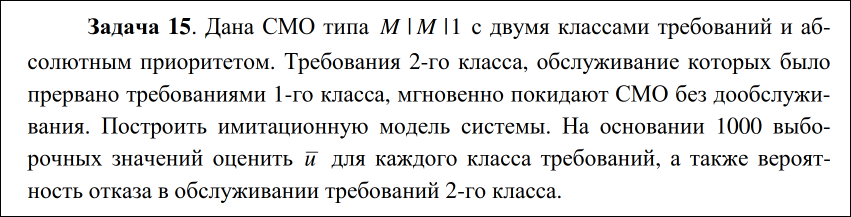

In [58]:
import random

# Параметры модели
lambda1 = 2     
lambda2 = 3     
mu = 5.0      # интенсивность обслуживаний
N = 1000      

lambda_total = lambda1 + lambda2  # суммарная интенсивность поступлений

t = 0.0 

next_arrival = t + random.expovariate(lambda_total)

# current_job - кортеж (job_class, arrival_time) для заявки, находящейся в обслуживании.
current_job = None
departure_time = float('inf') 

# Очереди ожидания: для каждого класса храним кортеж (job_class, arrival_time)
queue1 = []  # для требований 1-го класса
queue2 = []  # для требований 2-го класса

# Счётчики поступлений по классам
total_arrivals = 0
total_arrivals_class1 = 0
total_arrivals_class2 = 0

# Для расчёта математического ожидания времени пребывания (u)
sum_sojourn_class1 = 0.0  # суммарное время пребывания для требований 1-го класса
sum_sojourn_class2 = 0.0  # суммарное время пребывания для требований 2-го класса
count_class1 = 0         
count_class2 = 0         

lost2_count = 0


# Моделирование продолжается, пока не сгенерируем N поступлений и система не опустеет.
while total_arrivals < N or current_job is not None or queue1 or queue2:
    # Определяем следующее событие: поступление или завершение обслуживания.
    # Если ещё поступления не исчерпаны, выбираем событие с минимальным временем.
    if total_arrivals < N:
        # Сравниваем время следующего поступления и время завершения обслуживания.
        if next_arrival <= departure_time:
            event_type = 'arrival'
            event_time = next_arrival
        else:
            event_type = 'departure'
            event_time = departure_time
    else:
        # Если поступлений больше не генерируем, остаются только события завершения обслуживания.
        event_type = 'departure'
        event_time = departure_time

    t = event_time

    # Обработка поступления: генерируем требование и определяем его класс
    if event_type == 'arrival':    
        total_arrivals += 1
        if random.random() < lambda1 / lambda_total:
            job_class = 'class1'
            total_arrivals_class1 += 1
        else:
            job_class = 'class2'
            total_arrivals_class2 += 1

        arrival_record = (job_class, t)

        # Обработка поступления в зависимости от состояния сервера:
        if current_job is None:
            # Если сервер свободен – начинаем обслуживание сразу.
            current_job = arrival_record
            departure_time = t + random.expovariate(mu)
        else:
            if job_class == 'class1':
                # Требование 1-го класса имеет абсолютный приоритет.
                if current_job[0] == 'class2':
                    # Прерываем обслуживание требования 2-го класса.
                    # Засчитываем время пребывания прерванного требования 2-го класса.
                    sojourn = t - current_job[1]
                    sum_sojourn_class2 += sojourn
                    count_class2 += 1
                    lost2_count += 1
                    # Начинаем обслуживание требования 1-го класса, поступившего в данный момент.
                    current_job = arrival_record
                    departure_time = t + random.expovariate(mu)
                else:
                    # Если сервер занят требованием 1-го класса, поступившее требование идёт в очередь.
                    queue1.append(arrival_record)
            else:
                # Требование 2-го класса: если сервер занят, добавляем в очередь.
                queue2.append(arrival_record)

        # Планируем следующее поступление, если общее число поступлений меньше N
        if total_arrivals < N:
            next_arrival = t + random.expovariate(lambda_total)
        else:
            next_arrival = float('inf')

    else:
        # Обработка завершения обслуживания (departure)
        finished_job = current_job
        sojourn = t - finished_job[1]  # время пребывания в системе = t - время поступления
        if finished_job[0] == 'class1':
            sum_sojourn_class1 += sojourn
            count_class1 += 1
        else:
            sum_sojourn_class2 += sojourn
            count_class2 += 1

        # Выбор следующего требования для обслуживания:
        # Абсолютный приоритет имеет очередь требований 1-го класса.
        if queue1:
            current_job = queue1.pop(0)
            departure_time = t + random.expovariate(mu)
        elif queue2:
            current_job = queue2.pop(0)
            departure_time = t + random.expovariate(mu)
        else:
            current_job = None
            departure_time = float('inf')

u1 = sum_sojourn_class1 / count_class1 if count_class1 > 0 else 0.0
u2 = sum_sojourn_class2 / count_class2 if count_class2 > 0 else 0.0

refusal_prob_class2 = lost2_count / total_arrivals_class2 if total_arrivals_class2 > 0 else 0.0

# Вывод результатов моделирования
print("Результаты моделирования (на основе {} поступлений):".format(N))
print("Класс 1: Всего поступило = {}, u1 (ср. время пребывания) = {:.3f}".format(total_arrivals_class1, u1))
print("Класс 2: Всего поступило = {}, u2 (ср. время пребывания) = {:.3f}, Вероятность отказа = {:.3f}"
      .format(total_arrivals_class2, u2, refusal_prob_class2))
print("Общее модельное время: {:.3f}".format(t))


Результаты моделирования (на основе 1000 поступлений):
Класс 1: Всего поступило = 394, u1 (ср. время пребывания) = 0.321
Класс 2: Всего поступило = 606, u2 (ср. время пребывания) = 1.503, Вероятность отказа = 0.264
Общее модельное время: 194.372
